In [1]:
import glob
import torch
import numpy as np
import torch.nn as nn
from pathlib import Path
import torch.optim as optim
from MITRotor import IEA10MW
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
rotor = IEA10MW()

In [3]:
def extract_columns(file_list):
    data_dict = {}
    
    for file in file_list:
        with open(file, 'r') as f:
            lines = f.readlines()
            
            # Skip the header line and extract columns 1, 4, and 5
            data = np.loadtxt(lines[1:])[:, [0, 3, 4]]
            
            # Use the filename without the path and extension as the dictionary key
            key = Path(file).parent.name
            data_dict[key] = data
    
    return data_dict

In [4]:
file_list = glob.glob("/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/*/input_sounding")

data = extract_columns(file_list)

t = np.linspace(0,2*np.pi,158)
r = np.linspace(0,1,26)

R, T = np.meshgrid(r, t)

X = R * np.sin(T)
Y = (R * np.cos(T)) * rotor.R + 378

In [5]:
fontsize = 24
plt.rcParams['xtick.labelsize'] = 20 
plt.rcParams['ytick.labelsize'] = 20 

plt.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

In [6]:
casenames = [r's0_v4', r'sn2_v2', r's0_v2',r's2_v2', r'sn4_v0', r'sn2_v0', r's0_v0', r's2_v0', r's4_v0', r'sn2_vn2', r's0_vn2', r's2_vn2', r's0_vn4']
# casenames = [r's0_v0']

wrfles_bem = []
for count, name in enumerate(casenames):
    wrfles_bem.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/10MW/gad_sweep/'+casenames[count]+'_new.npz')))

/tmp/ipykernel_219446/495085630.py:45: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)
/tmp/ipykernel_219446/495085630.py:56: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)
/tmp/ipykernel_219446/495085630.py:80: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)


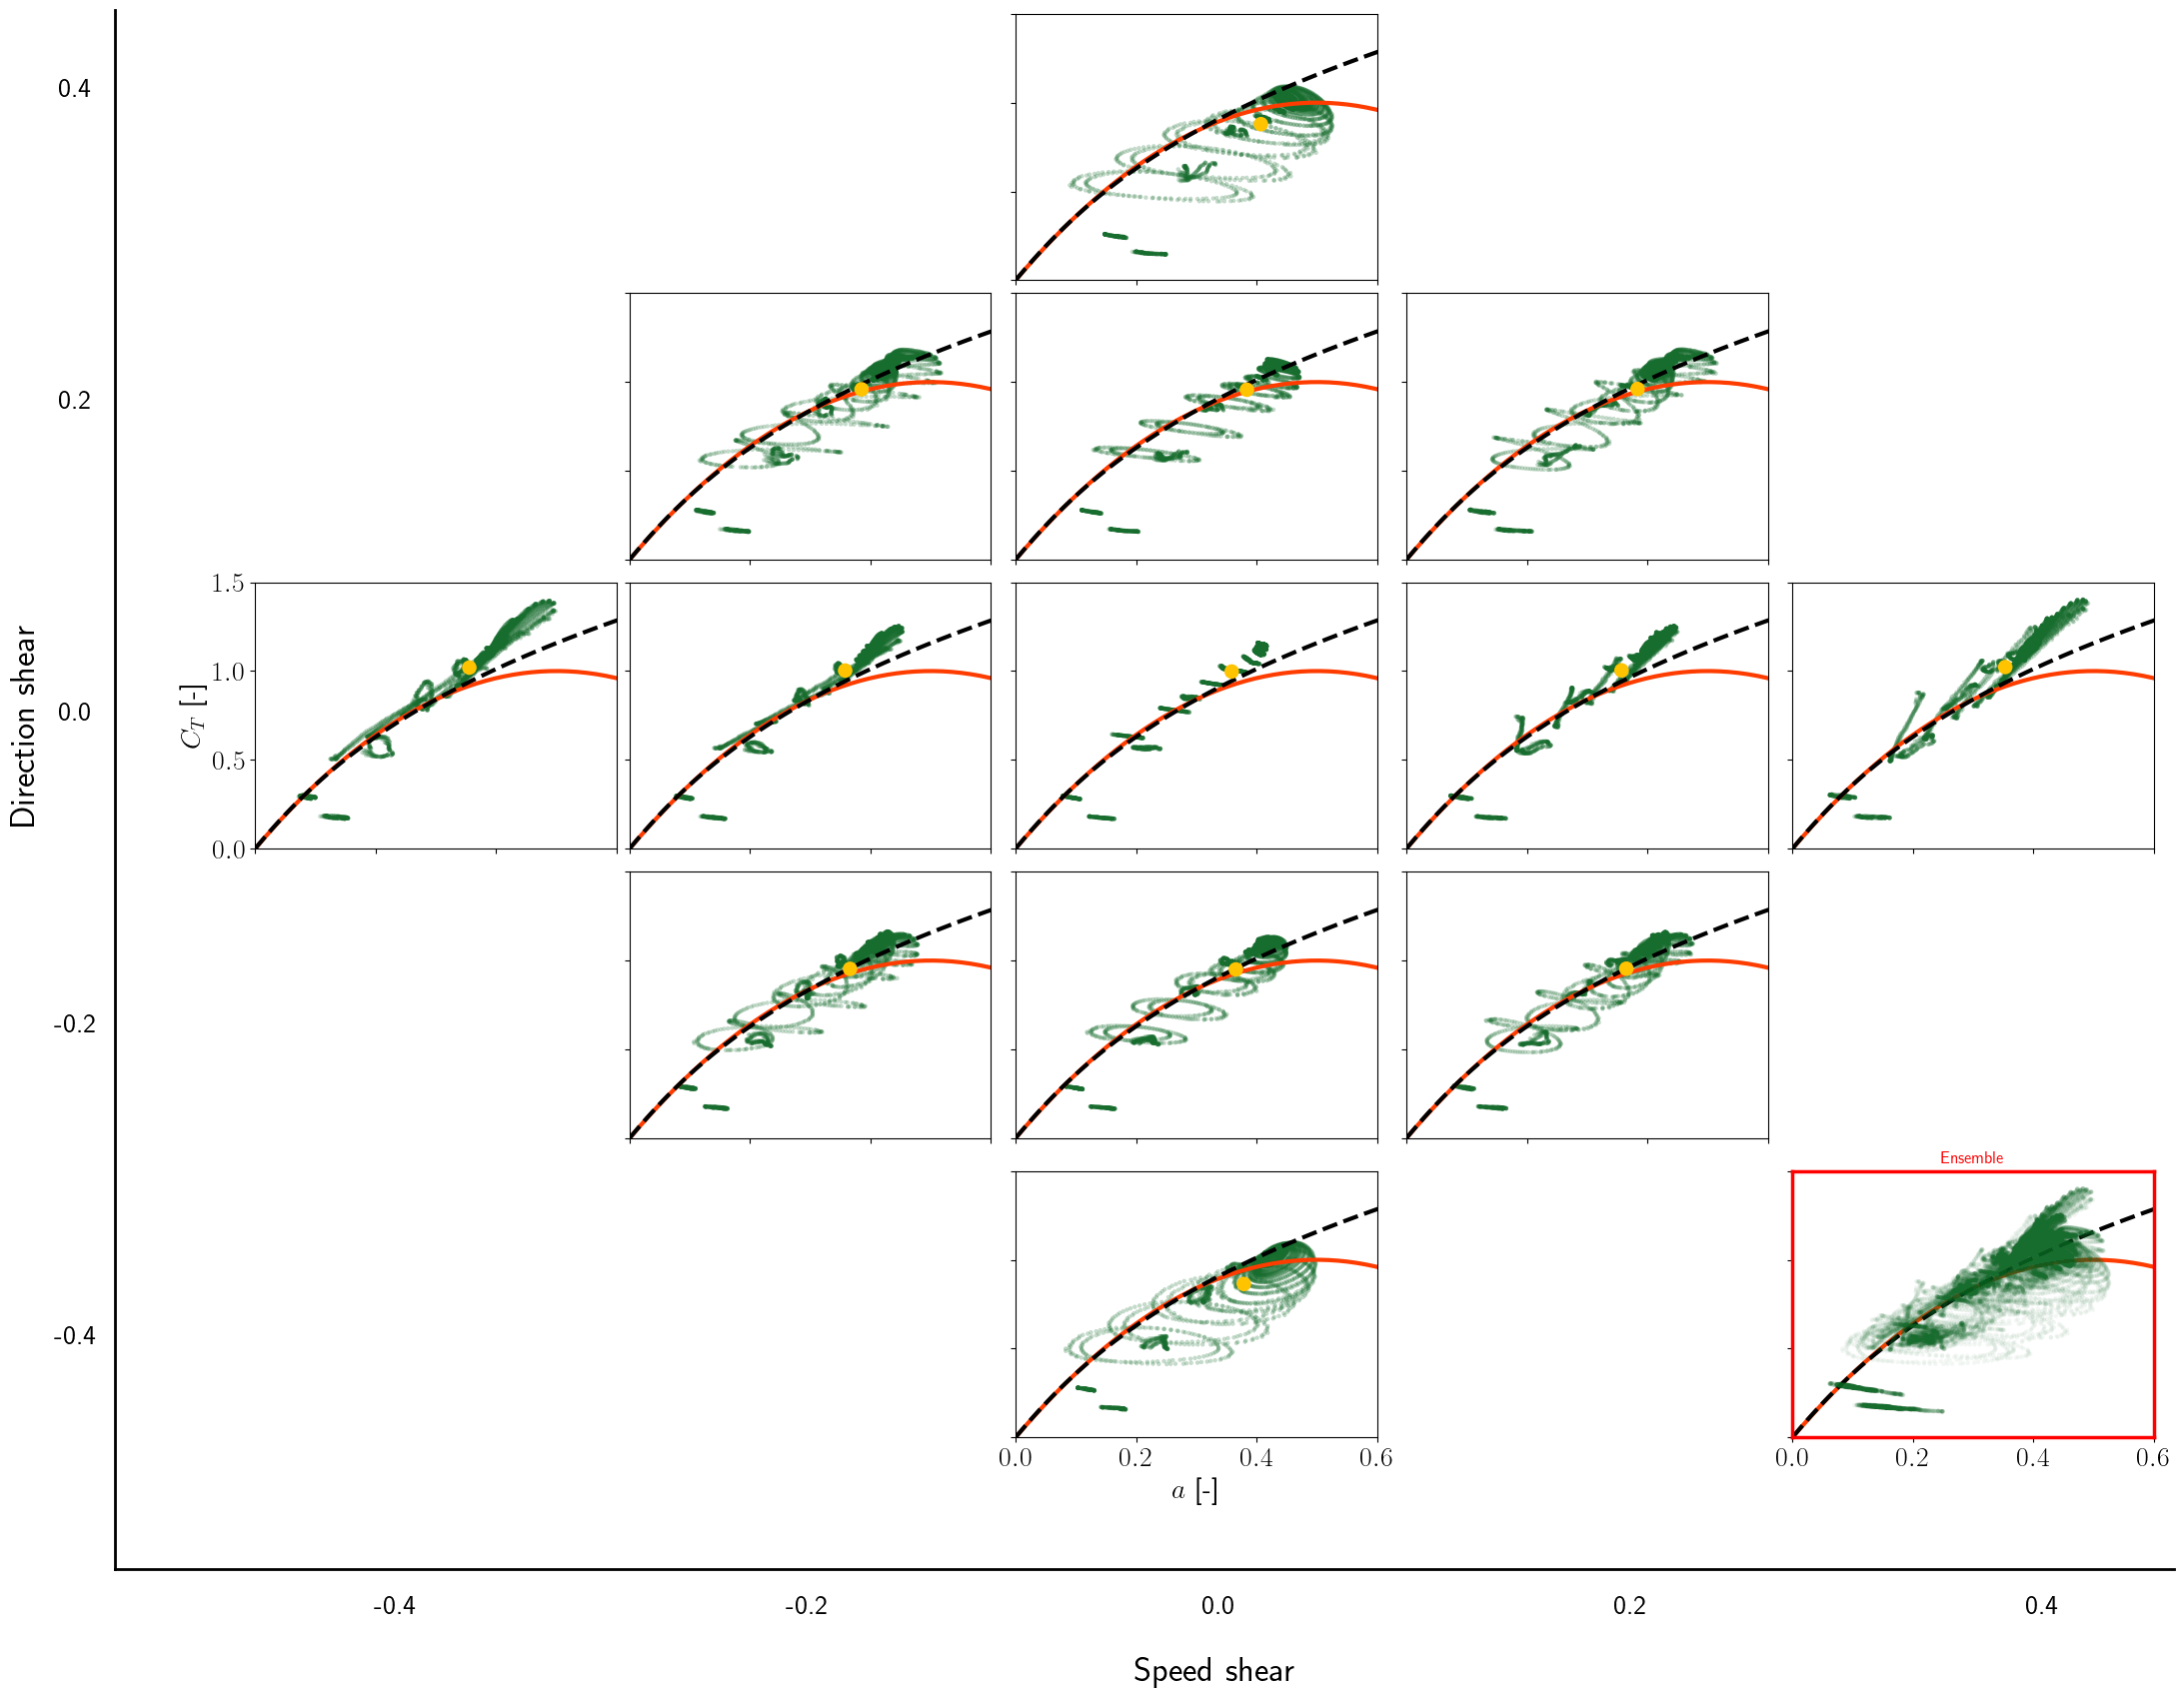

In [7]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

ind = np.zeros((26, 158, len(xs)))
ct  = np.zeros((26, 158, len(xs)))

for count,case in enumerate(casenames):
    u_func = interp1d(data[case][:,0], data[case][:,1], kind='linear')
    v_func = interp1d(data[case][:,0], data[case][:,2], kind='linear')

    u_inf = u_func(Y)
    v_inf = v_func(Y)

    # Get radial points
    a = ((wrfles_bem[count]['rOverR'] * rotor.R) - rotor.hub_radius)/rotor.R
    r = (rotor.hub_radius + a * (rotor.R - rotor.hub_radius)) / rotor.R

    # Compute induction
    ind[:,:,count] = 1 - np.mean(wrfles_bem[count]['u'],axis=0) / u_inf.T

    phi = np.deg2rad(np.mean(wrfles_bem[count]['phi'], axis=0))
    Cl = np.mean(wrfles_bem[count]['cl'], axis=0)
    Cd = np.mean(wrfles_bem[count]['cd'], axis=0)

    r =  (np.ones_like(Cd.T) * r).T

    # Solidity
    sigma = rotor.solidity_func(r)

    # Relative velocity
    W = np.mean(wrfles_bem[count]['vrel'], axis=0) / ((u_inf**2 + v_inf**2)**(1/2)).T
    # W = np.mean(wrfles_bem[count]['vrel'], axis=0) / 7


    # Axial coefficient
    Cax = Cl * np.cos(phi) + Cd * np.sin(phi)

    # Local CT
    ct[:,:,count] = sigma * W**2 * Cax

    # ind = k3 * ct**3 + k2 * ct**2 + k1 * ct

    mesh = ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=0.25,zorder=1)

    ct_annular  = 1/(2 * np.pi) * np.trapezoid(ct[:,:,count], np.linspace(0, 2*np.pi, 158), axis=-1)
    ind_annular = 1/(2 * np.pi) * np.trapezoid(ind[:,:,count], np.linspace(0, 2*np.pi, 158), axis=-1)

    # ct_annular  = 1/(2 * np.pi) * np.trapezoid(ct, np.linspace(0, 2*np.pi, 158))
    # ind_annular = 1/(2 * np.pi) * np.trapezoid(ind, np.linspace(0, 2*np.pi, 158))

    ct_rotor = 2 * np.trapezoid(ct_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])
    ind_rotor = 2 * np.trapezoid(ind_annular * wrfles_bem[count]['rOverR'], wrfles_bem[count]['rOverR'])

    mesh = ax[xs[count],ys[count]].scatter(ind_rotor, ct_rotor, cmap='viridis', s=110, edgecolor='none',color='#ffc300',alpha=1,zorder=4)

    # mesh = ax[xs[count],ys[count]].scatter(ind, ct, cmap='viridis', s=25, edgecolor='k')

    # ax[xs[count],ys[count]].invert_yaxis()
    # ax[xs[count],ys[count]].set_xticklabels([])
    # ax[xs[count],ys[count]].set_yticklabels([])
    # ax[xs[count],ys[count]].set_xticks([])
    # ax[xs[count],ys[count]].set_yticks([])
    a_mom = np.linspace(0,0.75,50)
    ct_mom = 4 * a_mom * (1 - a_mom)
    ax[xs[count],ys[count]].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=2)

    ct_mad = np.linspace(0,1.75,75)
    k1 = 0.2460
    k2 = 0.0586
    k3 = 0.0883
    a_mad = k3 * ct_mad**3 + k2 * ct_mad**2 + k1 * ct_mad
    ax[xs[count],ys[count]].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=3)

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
# ax[4,4].axis('off')
for spine in ax[4,4].spines.values():
    spine.set_linewidth(2.5)
    spine.set_edgecolor('red')

ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
ax[4,4].set_title('Ensemble', fontweight='bold',color='r')

ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
ax[4,2].set_xlabel('$a$ [-]', fontsize=20)
# Add a single colorbar on the right-hand side
# cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
# cbar.set_label('Deviation in axial force from uniform [\%]',fontsize=25)


# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)

# plt.figure(dpi=700)
plt.savefig(f"/scratch/09909/smata/wrf_les_sweep/wrf_local.png", bbox_inches="tight", dpi=600)
plt.show()

#### divider


In [10]:
# 1. Prepare the dataset with multiple (z1, z2) cases
def prepare_data(dataset_list):
    """Takes a list of (z1, z2, x_matrix, y_matrix) and prepares training data."""
    all_X_train = []
    all_Y_train = []
    all_X_val = []
    all_Y_val = []

    for z1, z2, x_matrix, y_matrix in dataset_list:
        r_flat = R.T.flatten()
        theta_flat = T.T.flatten()
        x_flat = x_matrix.flatten()
        y_flat = y_matrix.flatten()
        z1_flat = np.full_like(r_flat, z1)
        z2_flat = np.full_like(r_flat, z2)

        inputs = np.column_stack([r_flat, theta_flat, z1_flat, z2_flat])
        outputs = np.column_stack([x_flat, y_flat])

        # Shuffle and split (80% train, 20% validation)
        indices = np.random.permutation(inputs.shape[0])
        split_idx = int(0.8 * inputs.shape[0])
        train_idx, val_idx = indices[:split_idx], indices[split_idx:]

        all_X_train.append(inputs[train_idx])
        all_Y_train.append(outputs[train_idx])
        all_X_val.append(inputs[val_idx])
        all_Y_val.append(outputs[val_idx])

    # Stack into final training and validation sets
    X_train = np.vstack(all_X_train)
    Y_train = np.vstack(all_Y_train)
    X_val = np.vstack(all_X_val)
    Y_val = np.vstack(all_Y_val)

    return X_train, Y_train, X_val, Y_val

# 2. Define a simple feed-forward neural network
class XY_Predictor(nn.Module):
    def __init__(self):
        super(XY_Predictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
            # nn.ReLU(),
            # nn.Linear(64, 2)  # Output x, y
        )

    def forward(self, x):
        return self.model(x)

# 3. Training function
def train_model(model, train_loader, val_loader, epochs=100, lr=0.001):
    """Train the neural network."""
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, Y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val_batch, Y_val_batch in val_loader:
                val_predictions = model(X_val_batch)
                val_loss += criterion(val_predictions, Y_val_batch).item()

        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.6f}, "
              f"Val Loss: {val_loss/len(val_loader):.6f}")

# 4. Prepare dataset and train the model
# Example dataset list: [(z1_1, z2_1, x_matrix_1, y_matrix_1), (z1_2, z2_2, x_matrix_2, y_matrix_2), ...]
dataset_list = [
    (4, 0,   ind[:,:,0],  ct[:,:,0]),
    (2, -2,  ind[:,:,1],  ct[:,:,1]),
    (2, 0,   ind[:,:,2],  ct[:,:,2]),
    (2, 2,   ind[:,:,3],  ct[:,:,3]),
    (0, -4,  ind[:,:,4],  ct[:,:,4]),
    (0, -2,  ind[:,:,5],  ct[:,:,5]),
    (0, 0,   ind[:,:,6],  ct[:,:,6]),
    (0, 2,   ind[:,:,7],  ct[:,:,7]),
    (0, 4,   ind[:,:,8],  ct[:,:,8]),
    (-2, -2, ind[:,:,9],  ct[:,:,9]),
    (-2, 0,  ind[:,:,10], ct[:,:,10]),
    (-2, 2,  ind[:,:,11], ct[:,:,11]),
    (-4, 0,  ind[:,:,12], ct[:,:,12]),
]

X_train, Y_train, X_val, Y_val = prepare_data(dataset_list)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Initialize model
model = XY_Predictor()

# Train the model
train_model(model, train_loader, val_loader, epochs=100)

# 5. Evaluation function
def evaluate_model(model, r, theta, z1_eval, z2_eval, x_true, y_true):
    """Evaluate the model on a specific (z1, z2) case."""
    # Prepare input
    X_eval = np.column_stack([r.flatten(), theta.flatten(),
                              np.full_like(r.flatten(), z1_eval),
                              np.full_like(r.flatten(), z2_eval)])
    X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

    # Get predictions
    model.eval()
    with torch.no_grad():
        predictions = model(X_eval_tensor).numpy()

    # Reshape predictions
    x_pred = predictions[:, 0].reshape(r.shape)
    y_pred = predictions[:, 1].reshape(r.shape)

    return x_pred, y_pred

# Example evaluation
# z1_eval, z2_eval = 4, 0  # Choose a test case
# x_true = ind[:,:,0]
# y_true = ct[:,:,0]  # Retrieve true x, y
# x_pred, y_pred = evaluate_model(model, R.T, T.T, z1_eval, z2_eval, x_true, y_true)


Epoch 1/100, Train Loss: 0.037673, Val Loss: 0.023601
Epoch 2/100, Train Loss: 0.017198, Val Loss: 0.010530
Epoch 3/100, Train Loss: 0.008293, Val Loss: 0.006150
Epoch 4/100, Train Loss: 0.005401, Val Loss: 0.004115
Epoch 5/100, Train Loss: 0.003683, Val Loss: 0.003225
Epoch 6/100, Train Loss: 0.002872, Val Loss: 0.002443
Epoch 7/100, Train Loss: 0.002539, Val Loss: 0.002097
Epoch 8/100, Train Loss: 0.002344, Val Loss: 0.002128
Epoch 9/100, Train Loss: 0.002252, Val Loss: 0.002030
Epoch 10/100, Train Loss: 0.002216, Val Loss: 0.002118
Epoch 11/100, Train Loss: 0.002175, Val Loss: 0.002158
Epoch 12/100, Train Loss: 0.002134, Val Loss: 0.002167
Epoch 13/100, Train Loss: 0.002095, Val Loss: 0.001901
Epoch 14/100, Train Loss: 0.002072, Val Loss: 0.001821
Epoch 15/100, Train Loss: 0.002080, Val Loss: 0.001882
Epoch 16/100, Train Loss: 0.002077, Val Loss: 0.001800
Epoch 17/100, Train Loss: 0.002077, Val Loss: 0.002087
Epoch 18/100, Train Loss: 0.002063, Val Loss: 0.002472
Epoch 19/100, Train

In [11]:
# Example evaluation
z1_eval, z2_eval = 0, 0  # Choose a test case
x_true = ind[:,:,6]
y_true = ct[:,:,6]  # Retrieve true x, y
x_pred, y_pred = evaluate_model(model, R.T, T.T, z1_eval, z2_eval, x_true, y_true)

/tmp/ipykernel_219446/1302491384.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
/tmp/ipykernel_219446/1302491384.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')


Text(0.5, 0, '$a$ [-]')

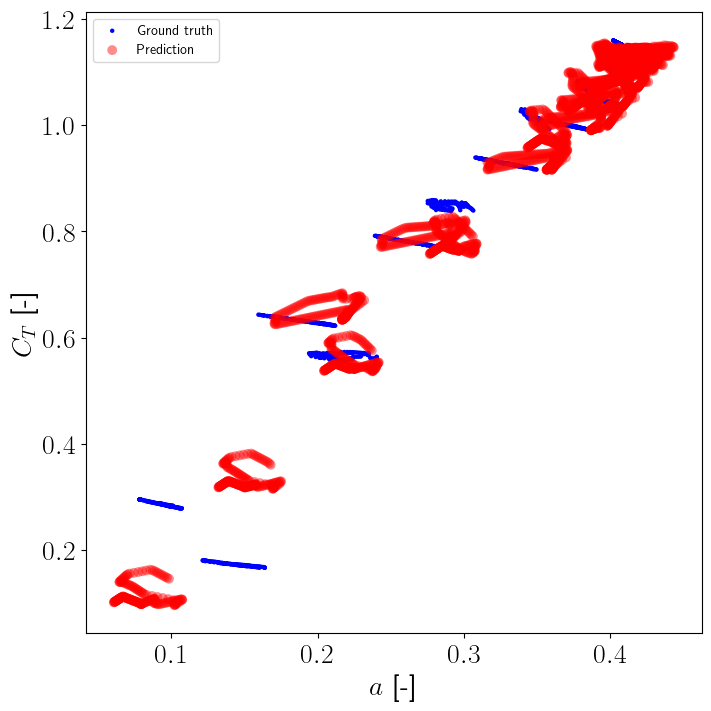

In [12]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True,sharex=True, sharey=True)

mesh = ax.scatter(ind[:,:,6], ct[:,:,6], cmap='viridis', s=10, edgecolor='none',color='b',zorder=3,alpha=1,label='Ground truth')
mesh = ax.scatter(x_pred, y_pred, cmap='viridis', s=50, edgecolor='none',color='r',zorder=3,alpha=0.45,label='Prediction')

ax.legend()

ax.set_ylabel('$C_T$ [-]', fontsize=20)
ax.set_xlabel('$a$ [-]', fontsize=20)

/tmp/ipykernel_219446/381297287.py:15: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_219446/381297287.py:16: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[xs[count],ys[count]].scatter(x_pred, y_pred, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')
/tmp/ipykernel_219446/381297287.py:92: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
/tmp/ipykernel_219446/381297287.py:93: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7,label='

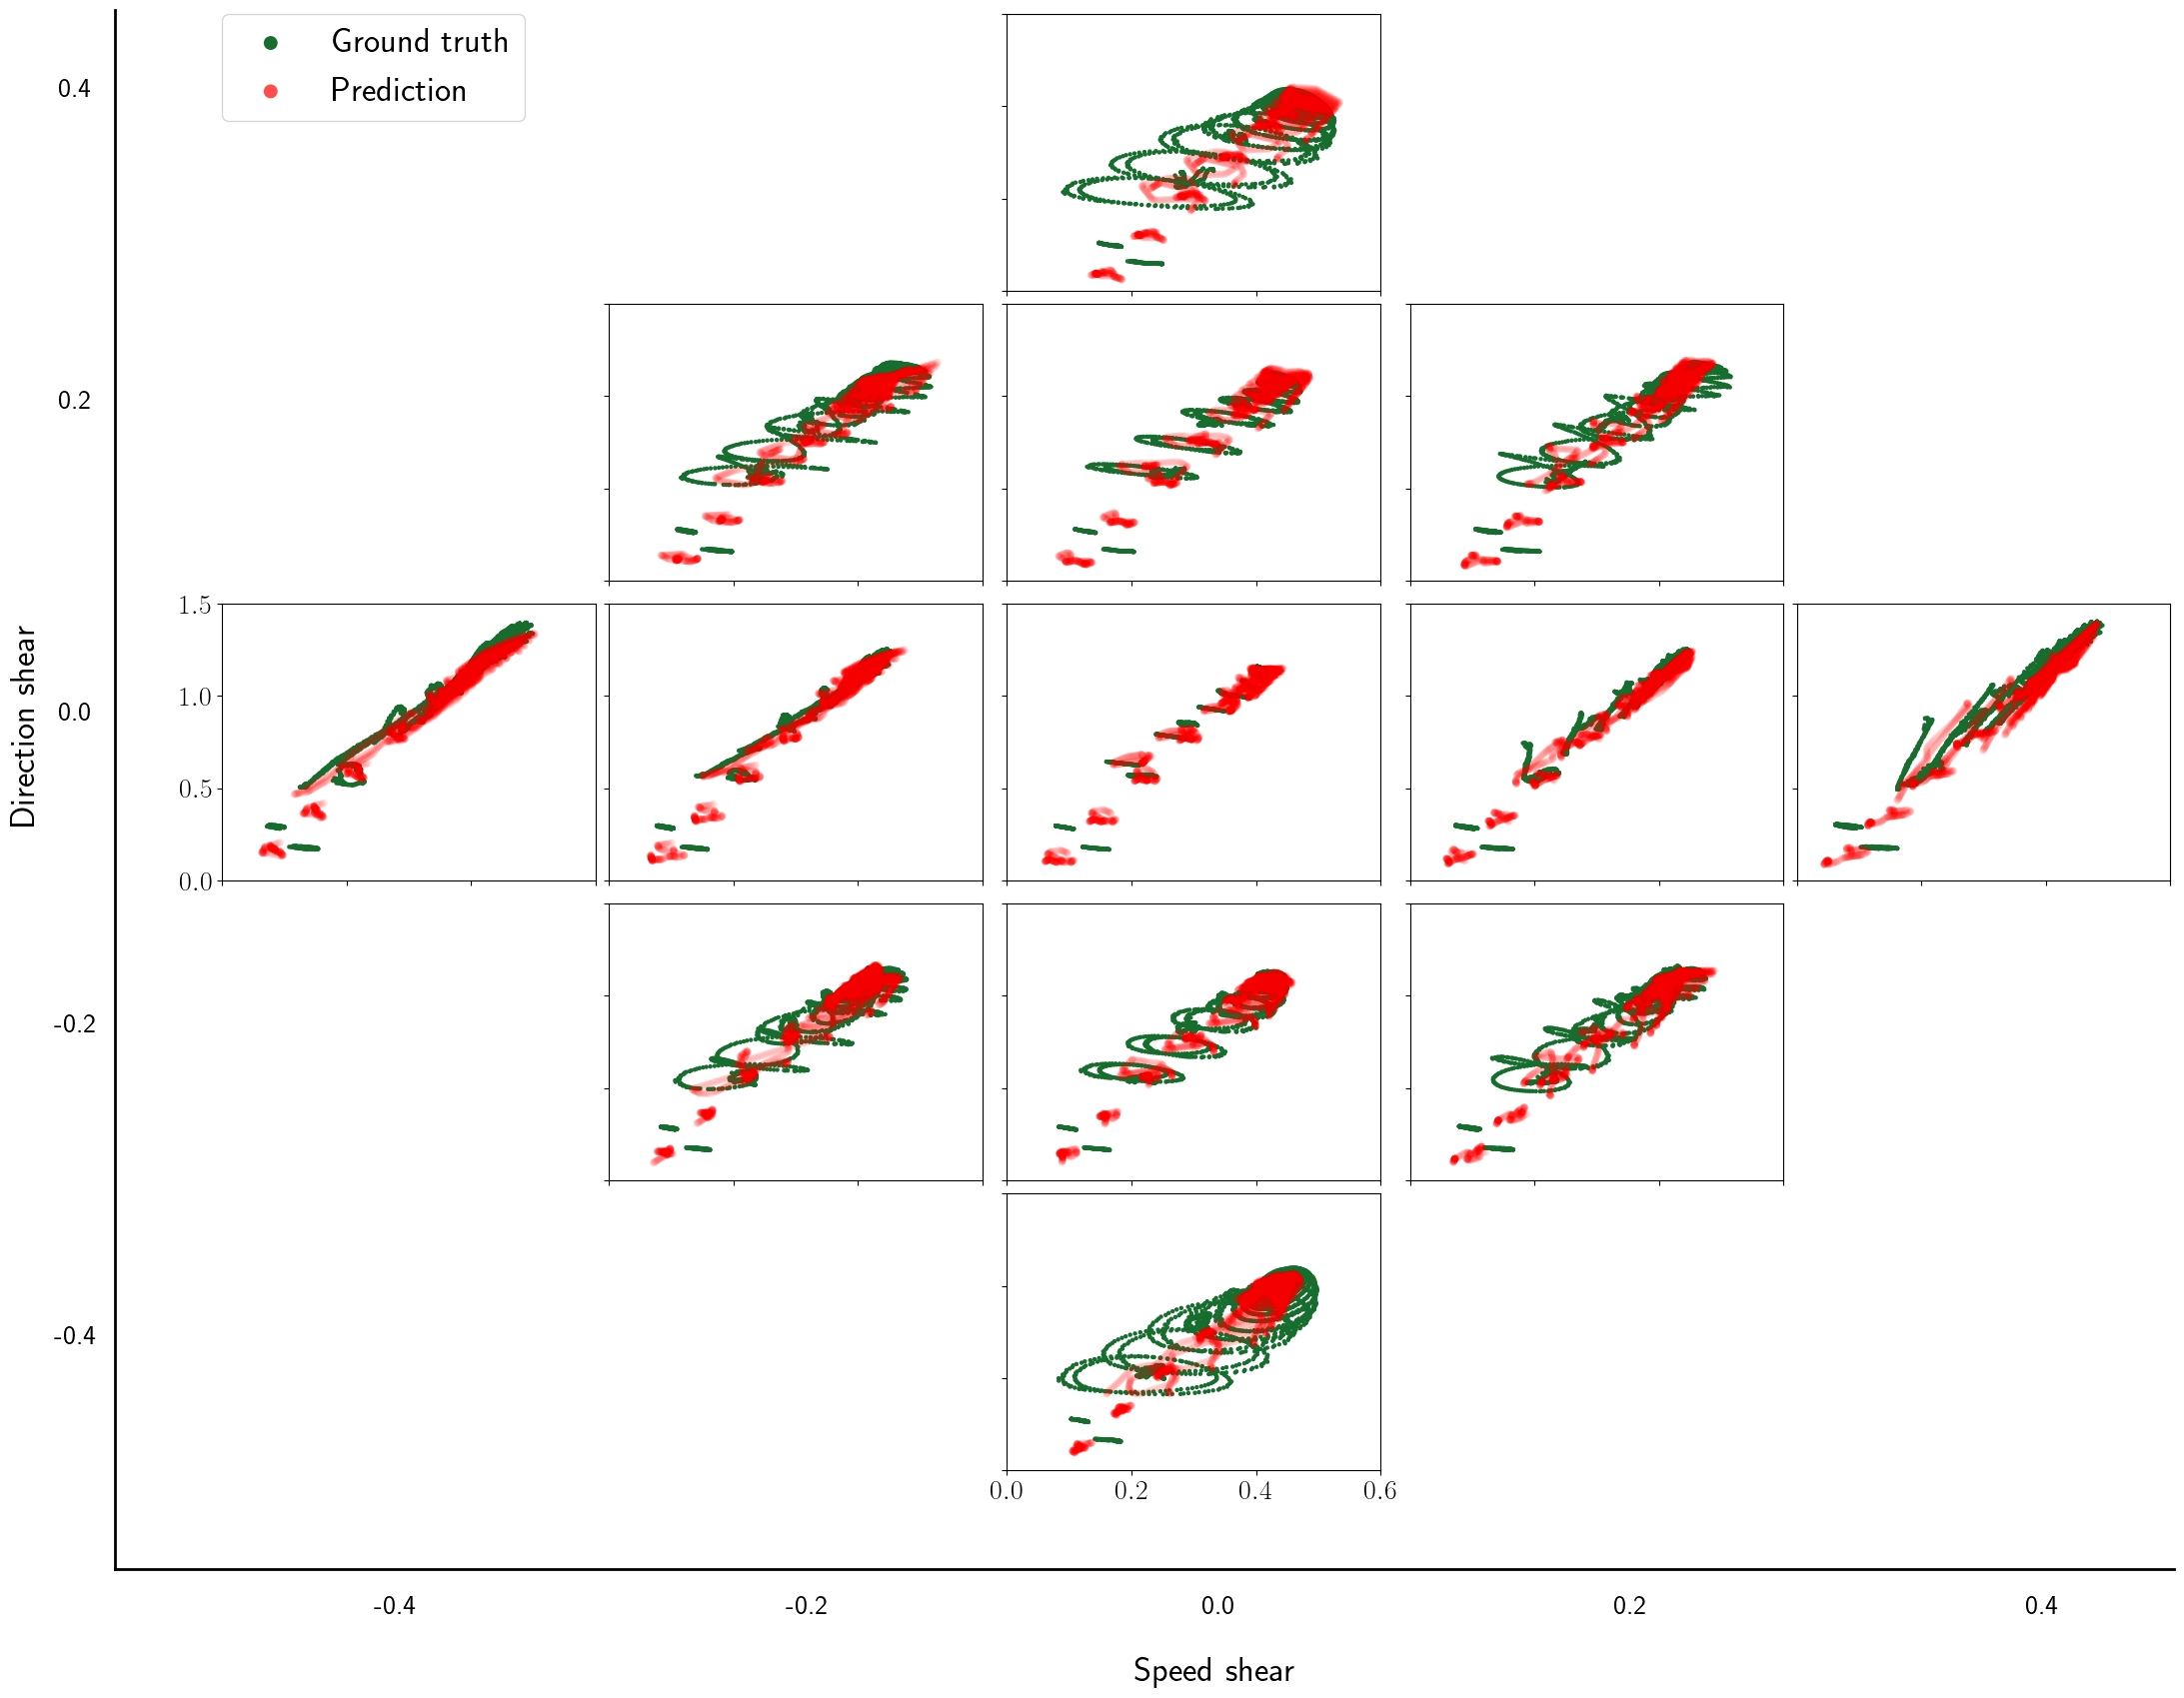

In [13]:
xs = [0,1,1,1,2,2,2,2,2,3,3,3,4]
ys = [2,1,2,3,0,1,2,3,4,1,2,3,2]

v_ref = [4, 2, 2, 2, 0, 0, 0, 0, 0, -2, -2, -2, -4]
s_ref = [0, -2, 0, 2, -4, -2, 0, 2, 4, -2, 0, 2, 0]

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20, 15), constrained_layout=True,sharex=True, sharey=True)

for count,case in enumerate(casenames):

    x_true = ind[:,:,count]
    y_true = ct[:,:,count]  # Retrieve true x, y
    x_pred, y_pred = evaluate_model(model, R.T, T.T, v_ref[count], s_ref[count], x_true, y_true)

    ax[xs[count],ys[count]].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
    ax[xs[count],ys[count]].scatter(x_pred, y_pred, cmap='viridis', s=30, edgecolor='none',color='r',alpha=0.085,label='Prediction')

    # ax[xs[count],ys[count]].set_aspect('equal')
    ax[xs[count],ys[count]].set_xlim([0,0.6])
    ax[xs[count],ys[count]].set_ylim([0,1.5])

    # ax[4,4].scatter(ind[:,:,count], ct[:,:,count], cmap='viridis', s=10, edgecolor='none',color='#176d2e',zorder=3,alpha=0.05)

ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,3].axis('off')
ax[0,4].axis('off')

ax[1,0].axis('off')
ax[1,4].axis('off')

ax[3,0].axis('off')
ax[3,4].axis('off')

ax[4,0].axis('off')
ax[4,1].axis('off')
ax[4,3].axis('off')
ax[4,4].axis('off')
# for spine in ax[4,4].spines.values():
#     spine.set_linewidth(2.5)
#     spine.set_edgecolor('red')

# ax[4,4].plot(a_mom, ct_mom, '#ff3c00',linewidth=3,zorder=1)
# ax[4,4].plot(a_mad, ct_mad, 'k--',linewidth=3,zorder=2)
# ax[4,4].set_title('Ensemble', fontweight='bold',color='r')

# ax[2,0].set_ylabel('$C_T$ [-]', fontsize=20)
# ax[4,2].set_xlabel('$a$ [-]', fontsize=20)
# Add a single colorbar on the right-hand side
# cbar = fig.colorbar(mesh, ax=ax, location='right', shrink=1)
# cbar.set_label('Deviation in axial force from uniform [\%]',fontsize=25)


# Add the number line below the subplots
line_y = -0.04  # Y-position for the line (below the subplots)
line_x_start, line_x_end = -0.03, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x_start, line_x_end], [line_y, line_y], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_x_start, line_x_end, 6)+0.14  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(pos, line_y - 0.03, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(0.52, line_y - 0.075, 'Speed shear', ha='center', fontsize=25)


line_x = -0.03  # Y-position for the line (below the subplots)
line_y_start, line_y_end = -0.04, 1  # Start and end positions of the line (normalized coordinates)

# Draw the line
fig.lines.extend([
    plt.Line2D([line_x, line_x], [line_y_start, line_y_end], color="black", transform=fig.transFigure, linewidth=2)
])

# Add text to the number line
positions = np.linspace(line_y_start, line_y_end, 6)+0.15  # Adjust the number of points and spacing
labels = ['-0.4', '-0.2', '0.0', '0.2', '0.4']  # Example labels

for pos, label in zip(positions, labels):
    fig.text(line_y - 0.01,pos, label, ha='center', fontsize=20)

# Add a title for the number line
fig.text(-0.075,0.46, 'Direction shear', ha='center', fontsize=25,rotation=90)

ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='#176d2e',alpha=1,label='Ground truth')
ax[0,0].scatter(-5,-5, cmap='viridis', s=100, edgecolor='none',color='r',alpha=0.7,label='Prediction')
ax[0,0].legend(loc='upper left',borderaxespad=0, fontsize=25)

# plt.figure(dpi=700)
# plt.savefig(f"/scratch/09909/smata/wrf_les_sweep/wrf_NN_.png", bbox_inches="tight", dpi=600)
plt.show()

## DIVIDER

In [44]:
width = 0.75
alpha = 1.0


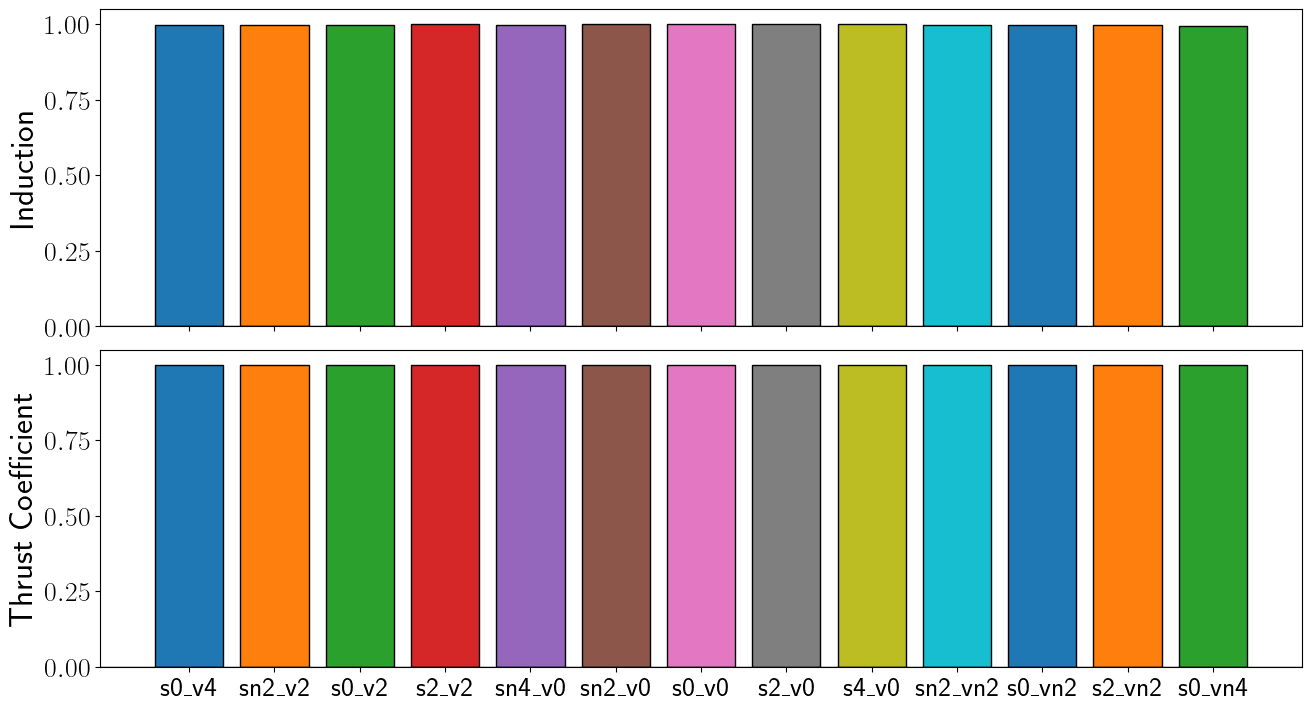

In [60]:
inds = np.arange(len(casenames))

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(13, 7), sharex=True, constrained_layout = True)
ax[0].axhline(0, color='black', linestyle='solid', linewidth=1)
ax[1].axhline(0, color='black', linestyle='solid', linewidth=1)

for count in range(len(casenames)):

    x_true = ind[:,:,count].flatten()
    y_true = ct[:,:,count].flatten()  # Retrieve true x, y
    x_pred, y_pred = evaluate_model(model, R.T, T.T, v_ref[count], s_ref[count], x_true, y_true)

    corr_x, _ = pearsonr(x_true, x_pred.flatten())
    corr_y, _ = pearsonr(y_true, y_pred.flatten())

    # print(corr_x)
    # print(corr_y)

    # induction
    ax[0].bar(inds[count], corr_x, edgecolor='black', alpha=alpha)
    ax[0].set_ylabel(r'Induction', fontsize=fontsize)
    # ax[0].text(inds[count], 21, f'{corr_x:0.2f}\%', ha='center', fontsize=15)
    # ax[0].set_ylim([-4.5,18])
    # ax[0].set_ylim([-7.2,25])

    # thrust
    ax[1].bar(inds[count],corr_y, edgecolor='black', alpha=alpha)
    ax[1].set_ylabel(r'Thrust Coefficient', fontsize=fontsize)
    # ax[1].text(ind[count], -4.75, f'{thrust[count]}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-5,1.5])
    # ax[1].text(inds[count], -8, f'{corr_y:0.2f}\%', ha='center', fontsize=15)
    # ax[1].set_ylim([-8.5,2.3])

    ax[1].set_xticks(inds)
    ax[1].set_xticklabels(casenames)

# plt.savefig("/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/figs/mit_freestream_no_ind_diffs.png", bbox_inches="tight", dpi=800)
plt.show()